# EP2 - MANDELBROT COM OPENMPI, OPENMPI-PTHREADS E OPENMPI-OPENMP

## Alunos

* Daniel Brasil Magnani - 12630214
* Felipe Martim Fernandes Vieira - 12630242
* Karina de Carvalho Froes - 9297655
* Magali Lemes do Sacramento - 10805420

## Descrição dos experimentos

Foram realizadas 15 medições variando-se o número de processos (podendo ser 1,8,16,32,64) e número de threads (uma potência de 2 entre $2^{0}$ e $2^{5}$) para o seguinte cenário fixo do conjunto Mandelbrot:
* Região: Triple Spiral Valley
* Tamanho de imagem: 4096

As bibliotecas utilizadas foram Pthreads, OpenMP e OpenMPI.

As visualizações foram criadas com seus devidos intervalos de confiança de 95% segundo a distribuição T Student com 14 graus de liberdade, dado o pequeno valor da amostra coletada para os experimentos.

O computador utilizado para executar os experimentos possui as seguintes configurações:
* Processador Intel(R) Xeon(R) CPU E5-2670 0 @ 2.60GHz
* 16 cores (2 Threads por core)
* 64GB de memória RAM
* Sistema operacional Debian 4.19.171-2.

## Análises e gráficos
Para começar a análise dos dados e sua visualização, precisamos importar as bibliotecas conforme comando abaixo:

In [1]:
import Pkg; Pkg.add("CSV"); Pkg.add("DataFrames"); Pkg.add("Gadfly"); Pkg.add("DataFramesMeta")

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


Fetching: [========================================>]  100.0 %

  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]


In [11]:
using CSV
using DataFrames
using DataFramesMeta
using Gadfly
# using CategoricalArrays
set_default_plot_size(25cm, 12cm)

In [12]:
df = DataFrame(CSV.File("results2.tsv", header=1, delim="\t"))
first(df, 5)

,Algorithm,Image,Size,Threads,Time,Stddev,Clock
,String,String,Int64,Int64,Float64,Float64,String
1,mandelbrot_ompi,triple_spiral.log,4096,1,32.04,1.15,"26,688.44"
2,mandelbrot_ompi,triple_spiral.log,4096,1,9.86,1.04,"40,245.54"
3,mandelbrot_ompi,triple_spiral.log,4096,1,7.972,0.435,"55,062.27"
4,mandelbrot_ompi,triple_spiral.log,4096,1,8.704,0.636,"113,943.64"
5,mandelbrot_ompi,triple_spiral.log,4096,1,9.303,0.285,"192,489.17"


Transformando em categóricas algumas colunas que estão como numéricas

In [13]:
df = @linq df |>
    transform(Threads = string.(:Threads)) |>
    transform(Tasks = string.(:Tasks));

Separando os dados relacionados a cada algoritmo em df diferentes:

In [14]:
## EP2
df_ompi = filter(row -> row.Algorithm == "mandelbrot_ompi", df)
df_ompi_pth = filter(row -> row.Algorithm == "mandelbrot_ompi_pth", df)
df_ompi_omp = filter(row -> row.Algorithm == "mandelbrot_ompi_omp", df)
first(df_ompi_omp, 5)


,Algorithm,Image,Size,Threads,Time,Stddev,Clock
,String,String,Int64,String,Float64,Float64,String
1,mandelbrot_ompi_omp,triple_spiral.log,4096,1,30.51,0.643,"26,991.99"
2,mandelbrot_ompi_omp,triple_spiral.log,4096,2,20.262,0.542,"29,662.62"
3,mandelbrot_ompi_omp,triple_spiral.log,4096,4,20.947,0.757,"30,954.01"
4,mandelbrot_ompi_omp,triple_spiral.log,4096,8,20.902,0.702,"31,423.06"
5,mandelbrot_ompi_omp,triple_spiral.log,4096,16,23.002,0.884,"31,600.72"


# Como e por que as três versões do programa se comportam com a variação:

## Do número de processos ?

Inicialmente vamos analisar separadamente o desempenho do algoritmo OMPI e em seguida dos 3 algoritmos juntos.

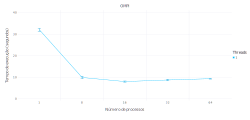

In [15]:
df_ompi1 = filter(row -> row.Threads == "1", df_ompi)

ymins = df_ompi1.Time .- 2.262 * (df_ompi1.Stddev / sqrt(14))
ymaxs = df_ompi1.Time .+ 2.262 * (df_ompi1.Stddev / sqrt(14))
plota2 = plot(df_ompi1,
    x=:Tasks, 
    y=:Time,
    Guide.xlabel("Número de processos"),
    Guide.ylabel("Tempo de execução (segundos)"),
    ymin=ymins,
    ymax=ymaxs,
    color=:Threads,
    Geom.line,
    Geom.errorbar,
    Guide.title("OMPI"))

In [16]:
df_compare = filter(row -> (row.Algorithm == "mandelbrot_ompi" && row.Tasks == "1") || row.Algorithm == "mandelbrot_seq", df)
df_compare[1:2, [:Algorithm,:Tasks,:Time, :Clock, :CPUs]]

,Algorithm,Tasks,Time,Clock,CPUs
,String,String,Float64,String,Float64
1,mandelbrot_ompi,1,32.04,"26,688.44",0.833
2,mandelbrot_seq,1,30.263,"25,776.05",0.852


A partir dos dados acima, podemos ver que ao executarmos o algoritmo OMPI com apenas 1 processo obteremos resultados similares ao algoritmo sequencial: a utilização de CPUs e o valor de Clock são muito semelhantes, de maneira que não temos vantagem na sua utilização frente ao sequencial. A pequena perda de desempenho observada na utilização do OpenMPI pode indicar um "overhead" desnecessário ao se utilizar o OpenMPI com somente uma tarefa.

Em contrapartida, ao se utilizar OMPI com um número de processos maior do que o número de processadores existentes, temos uma situação de oversubscription: pode-se observar que o valor de processos = 64 não nos trouxe ganho em tempo computacional. Dessa maneira, para o algoritmo OMPI alcançamos o melhor desempenho com número de processos = 16, resultando no tempo de 7,972s.

Logo abaixo analisaremos o desempenho geral dos 3 algoritmos: OMPI, OMPI-PTHREADS e OMPI-OMP.

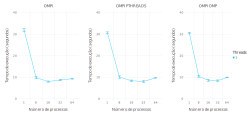

In [17]:
df_ompi_pth1 = filter(row -> row.Threads == "1", df_ompi_pth)
df_ompi_omp1 = filter(row ->row.Threads == "1", df_ompi_omp)


ymins = df_ompi1.Time .- 2.262 * (df_ompi1.Stddev / sqrt(14))
ymaxs = df_ompi1.Time .+ 2.262 * (df_ompi1.Stddev / sqrt(14))
plota1 = plot(df_ompi1,
    x=:Tasks, 
    y=:Time,
    Guide.xlabel("Número de processos"),
    Guide.ylabel("Tempo de execução (segundos)"),
    ymin=ymins,
    ymax=ymaxs,
    color=:Threads,
    Geom.line,
    Geom.errorbar,
    Guide.title("OMPI"),
    Theme(key_position = :none))

ymins = df_ompi_pth1.Time .- 2.262 * (df_ompi_pth1.Stddev / sqrt(14))
ymaxs = df_ompi_pth1.Time .+ 2.262 * (df_ompi_pth1.Stddev / sqrt(14))
plota2 = plot(df_ompi_pth1,
    x=:Tasks, 
    y=:Time,
    Guide.xlabel("Número de processos"),
    Guide.ylabel("Tempo de execução (segundos)"),
    ymin=ymins,
    ymax=ymaxs,
    color=:Threads,
    Geom.line,
    Geom.errorbar,
    Guide.title("OMPI PTHREADS"),
    Theme(key_position = :none))

ymins = df_ompi_omp1.Time .- 2.262 * (df_ompi_omp1.Stddev / sqrt(14))
ymaxs = df_ompi_omp1.Time .+ 2.262 * (df_ompi_omp1.Stddev / sqrt(14))
plota3 = plot(df_ompi_omp1,
    x=:Tasks, 
    y=:Time,
    Guide.xlabel("Número de processos"),
    Guide.ylabel("Tempo de execução (segundos)"),
    ymin=ymins,
    ymax=ymaxs,
    color=:Threads,
    Geom.line,
    Geom.errorbar,
    Guide.title("OMPI OMP"))



hstack(plota1,plota2, plota3)

Filtrando os dados relativos a uma única thread, podemos observar como dito anteriormente, que o melhor número de processos para OMPI é 16 e já para os demais algoritmos é 32, embora o intervalo de confiança indique que não há um diferença muito significativa entre 16 e 32 processos. Além disso, notamos que até 16 processos os 3 algoritmos apresentam tempos semelhantes e que os algoritmos OMPI-Pthreads e OMPI-OMP apresentam comportamentos semelhantes em relação aos diferentes números de processos.

## Do número de Threads ?

Aqui vamos demonstrar o impacto da variação do número de threads na performance do tempo dos algoritmos OMPI-Pthreads e OMPI-OMP.

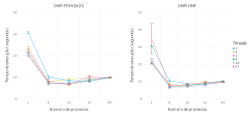

In [18]:
ymins = df_ompi_pth.Time .- 2.262 * (df_ompi_pth.Stddev / sqrt(14))
ymaxs = df_ompi_pth.Time .+ 2.262 * (df_ompi_pth.Stddev / sqrt(14))
plota2 = plot(df_ompi_pth,
    x=:Tasks, 
    y=:Time,
    Guide.xlabel("Número de processos"),
    Guide.ylabel("Tempo de execução (segundos)"),
    ymin=ymins,
    ymax=ymaxs,
    color=:Threads,
    Geom.line,
    Geom.errorbar,
    Guide.title("OMPI PTHREADS"),
    Theme(key_position = :none))

ymins = df_ompi_omp.Time .- 2.262 * (df_ompi_omp.Stddev / sqrt(14))
ymaxs = df_ompi_omp.Time .+ 2.262 * (df_ompi_omp.Stddev / sqrt(14))
plota3 = plot(df_ompi_omp,
    x=:Tasks, 
    y=:Time,
    Guide.xlabel("Número de processos"),
    Guide.ylabel("Tempo de execução (segundos)"),
    ymin=ymins,
    ymax=ymaxs,
    color=:Threads,
    Geom.line,
    Geom.errorbar,
    Guide.title("OMPI OMP"))



hstack(plota2, plota3)

Com esses gráficos, pode-se observar uma diferença marcante entre os 2 algoritmos: ao lançarmos 32 threads no OMPI-OMP com apenas 1 processo, temos um desvio padrão elevado e que atinge os maiores tempos observados para o algoritmo. Já ao lançarmos apenas 1 processo no OMP-Pthreads, ao aumentarmos a quantidade de threads, menor se torna o tempo. No entanto, ao aumentar o número de processos, os 2 algoritmos seguem padrões de tempo semelhantes como destacado anteriormente.

Nota-se também, como explicitado na tabela abaixo, que o desempenho dos algoritmos com 32 threads piorou quando utilizamos MPI com apenas 1 tarefa.

In [19]:
df_compare_2 = filter(row -> (row.Algorithm == "mandelbrot_omp" && row.Tasks == "1" && row.Threads == "32") ||
                             (row.Algorithm == "mandelbrot_pth" && row.Tasks == "1" && row.Threads == "32") ||
                             (row.Algorithm == "mandelbrot_ompi_pth" && row.Tasks == "1" && row.Threads == "32") ||
                             (row.Algorithm == "mandelbrot_ompi_omp" && row.Tasks == "1" && row.Threads == "32"), df)

,Algorithm,Image,Size,Threads,Time,Stddev,Clock
,String,String,Int64,String,Float64,Float64,String
1,mandelbrot_pth,triple_spiral.log,4096,32,6.068,0.725,"40,591.14"
2,mandelbrot_omp,triple_spiral.log,4096,32,6.209,0.511,"39,773.27"
3,mandelbrot_ompi_pth,triple_spiral.log,4096,32,19.882,0.211,"33,357.80"
4,mandelbrot_ompi_omp,triple_spiral.log,4096,32,34.76,14.57,"31,656.59"


Como o computador usado para a realização dos experimentos é multi-core, ao utilizarmos MPI e dada a disponibilidade, cada processo é executado em um núcleo. O comportamento de menor desempenho visto acima pode ser explicado pelo fato de que, ao definirmos somente uma tarefa, condicionamos as threads a serem executadas em apenas um núcleo. Quando não utilizamos o MPI, as threads são executadas em diferentes processadores, o que possibilita execuções verdadeiramente concorrentes e, consequentemente, um desempenho melhor.

Além disso, agora é possível perceber que podemos encontrar os menores valores de tempo no número de processos = 8 para OMPI-OMP e para OMPI-Pthread. Vemos que esse valor se encontra entre número de processos = 8 ou 16. Vamos ampliar agora essa região de interesse para determinar com precisão o valor ótimo para threads e processos em ambos os algoritmos.

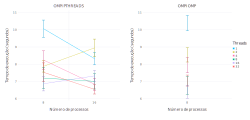

In [20]:
df_ompi_pth_zoom = filter(row -> row.Tasks == "8" || row.Tasks == "16", df_ompi_pth)
df_ompi_omp_zoom = filter(row -> row.Tasks == "8", df_ompi_omp)


ymins = df_ompi_pth_zoom.Time .- 2.262 * (df_ompi_pth_zoom.Stddev / sqrt(14))
ymaxs = df_ompi_pth_zoom.Time .+ 2.262 * (df_ompi_pth_zoom.Stddev / sqrt(14))
plota2 = plot(df_ompi_pth_zoom,
    x=:Tasks, 
    y=:Time,
    Guide.xlabel("Número de processos"),
    Guide.ylabel("Tempo de execução (segundos)"),
    ymin=ymins,
    ymax=ymaxs,
    color=:Threads,
    Geom.line,
    Geom.errorbar,
    Guide.title("OMPI PTHREADS"),
    Theme(key_position = :none))

ymins = df_ompi_omp_zoom.Time .- 2.262 * (df_ompi_omp_zoom.Stddev / sqrt(14))
ymaxs = df_ompi_omp_zoom.Time .+ 2.262 * (df_ompi_omp_zoom.Stddev / sqrt(14))
plota3 = plot(df_ompi_omp_zoom,
    x=:Tasks, 
    y=:Time,
    Guide.xlabel("Número de processos"),
    Guide.ylabel("Tempo de execução (segundos)"),
    ymin=ymins,
    ymax=ymaxs,
    color=:Threads,
    Geom.line,
    Geom.errorbar,
    Guide.title("OMPI OMP"))



hstack(plota2, plota3)

Nesses gráficos, agora filtrados com as regiões de interesse, vemos que o menor tempo encontrado para o algoritmo OMPI-Pthreads é atingido com número de processos = 16 e número de threads = 32 e para OMPI-OMP temos número de processos = 8 e número de threads = 16. 

### Comparação entre todos os métodos ###

Nesta seção comparamos os tempos de execução dos seis métodos aplicados, a saber: (1) Sequencial, (2) PThreads, (3) OpenMP, (4) OpenMPI, (5) OpenMPI+Pthreads, (6) OpenMPI+OpenMP. Os parâmetros utilizados foram os melhores obtidos para cada método durante os testes, como segue:

* Tamanho da imagem: 4096
* Região: Triple Spiral
* Número de testes: 15
* Para Pthreads (2) e OpenMP (3): 32 threads
* Para OpenMPI (4): 16 processos
* Para OpenMPI+Pthreads (5): 16 processos e 32 threads
* Para OpenMPI+OpenMP (6): 8 processos e 16 threads

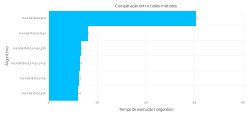

In [21]:
df_all = filter(row -> row.Algorithm == "mandelbrot_seq" || 
                row.Algorithm == "mandelbrot_pth" || 
                row.Algorithm == "mandelbrot_omp" ||
                (row.Algorithm == "mandelbrot_ompi" && row.Tasks == "16") ||
                (row.Algorithm == "mandelbrot_ompi_pth" && row.Tasks == "16" && row.Threads == "32") ||
                (row.Algorithm == "mandelbrot_ompi_omp" && row.Tasks == "8" && row.Threads == "16"), df)

df_all = sort(df_all, :Time, rev = true)
ymins = df_all.Time .- 2.262 * (df_all.Stddev / sqrt(14))
ymaxs = df_all.Time .+ 2.262 * (df_all.Stddev / sqrt(14))
plot(df_all,
    x=:Time, 
    y=:Algorithm,
    Coord.cartesian(yflip=true),
    Guide.xlabel("Tempo de execução (segundos)"),
    Guide.ylabel("Algoritmo"),
    Guide.yticks(orientation=:horizontal),
    Scale.y_discrete,
    xmin=ymins, xmax=ymaxs, Geom.errorbar, 
    Geom.bar(orientation=:horizontal),
    Theme(bar_spacing=0mm, stroke_color=c->"gray"),
    Guide.title("Comparação entre todos métodos")
)

Podemos observar que o método mais lento foi o sequencial. Como este método não explora o paralelismo do processamento, o tempo de execução é maior. Em seguida, aparecem os três métodos que utilizam OpenMPI, e por fim, os métodos mais rápidos foram OpenMP e Pthreads. Podemos explicar a vantagem do Pthreads e OpenMP por serem métodos de paralelismo de threads, em contraste com OpenMPI, que fazem paralelismo de processos. A criação e execução de threads é mais rápida que processos, pois compartilham recursos entre si, por isso são mais leves. Além disso o processador consegue executar duas threads por core, aumentando a capacidade de paralelismo. Isso explica também o ganho ao combinar OpenMPI com Pthreads ou OpenMP.



## Conclusões ##

Os experimentos evidenciaram que o uso da biblioteca OpenMPI pode resultar em ganhos de performance robustos. No entanto, devemos observar caso a caso, pois a paralelização dos processos gera overhead, e não é vantajosa quando há mais processos que processadores disponíveis. Também foi possível observar que, comparado com as bibliotecas de paralelização em nível de thread (Pthreads e OpenMP), a performance do OpenMPI foi pior. Por outro lado, OpenMPI é mais flexível, e pode ser executada em várias máquinas em paralelo. Portanto o ideal é pesar os prós e contras de cada abordagem para escolher o método mais eficiente.